In [6]:
import wfdb
import pywt
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from PIL import Image

In [2]:
def generate_scalogram(signal, filename):
    scales = np.arange(1, 128)
    coef, _ = pywt.cwt(signal, scales, 'morl')
    plt.imshow(coef, cmap='jet', aspect='auto')
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close()

In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% train, 20% validation
)

train_gen = datagen.flow_from_directory(
    './cwt_images',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for 3+ classes
    subset='training'
)

val_gen = datagen.flow_from_directory(
    './cwt_images',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 5200 images belonging to 5 classes.
Found 1300 images belonging to 5 classes.


In [4]:
# 1. Load Pretrained ResNet50 (excluding top layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# 2. Freeze base model
base_model.trainable = False

In [7]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(5, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(train_gen, validation_data=val_gen, epochs=10)
model.save('ecg_model_resnet50_epochs-10.h5')

C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 504s 3s/step - accuracy: 0.2439 - loss: 1.6138 - val_accuracy: 0.2785 - val_loss: 1.5252
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.3436 - loss: 1.5239 - val_accuracy: 0.4538 - val_loss: 1.4936
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.4687 - loss: 1.4863 - val_accuracy: 0.4931 - val_loss: 1.4623
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.5171 - loss: 1.4594 - val_accuracy: 0.5008 - val_loss: 1.4300
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.5191 - loss: 1.4291 - val_accuracy: 0.5238 - val_loss: 1.3987
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.5257 - loss: 1.3961 - val_accuracy: 0.6223 - val_loss: 1.3716
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.5876 - loss: 1.3614 - val_accuracy: 0.5800 - val_loss: 1.3345
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.5971 - loss: 1.3299 - val_accu

In [9]:
loss, accuracy = model.evaluate(val_gen)
print(f"Test Accuracy: {accuracy*100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5852 - loss: 1.2253
Test Accuracy: 58.38%


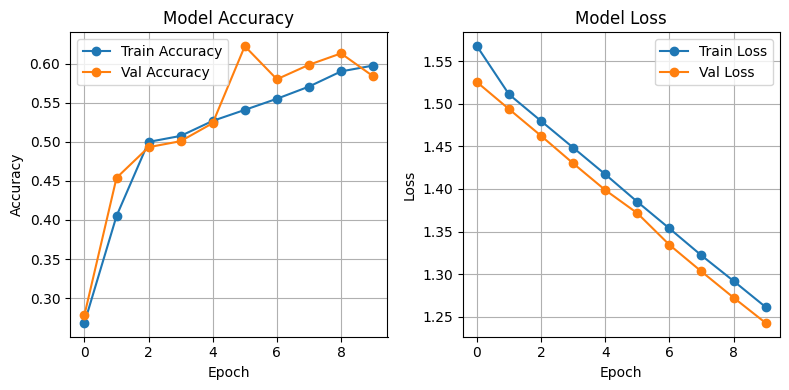

<Figure size 640x480 with 0 Axes>

In [10]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig('training_curves_for_ecg_mmodel.png')

In [11]:
def load_user_signal(folder_path, record_name='sample'):
    record = wfdb.rdrecord(f"{folder_path}/{record_name}")
    signal = record.p_signal[:, 0]  # First lead
    fs = record.fs
    return signal[:2*fs], fs  # First 2 seconds

In [12]:
print(train_gen.class_indices)

{'arrhythmia': 0, 'artial_shuffled': 1, 'malignant_shuffled': 2, 'normal': 3, 'st_shuffled': 4}


In [13]:
def predict_heart_condition(model_path, img_path):
    model = load_model(model_path)
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0]
    predicted_class = np.argmax(prediction)
    class_labels = ['arrhythmia','artial','malignant', 'normal', 'st-change']
    return class_labels[predicted_class]

In [38]:
signal, fs = load_user_signal('./user/normal','./16786')  # Assuming user_ecg.dat/.hea exists
generate_scalogram(signal, 'user_scalogram.png')
result = predict_heart_condition('ecg_model_resnet50_epochs-10.h5', 'user_scalogram.png')
print("Prediction:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: normal


In [15]:
def complete_pipeline_1(folder_path,record_name,output_path,model_path):
    signal, fs = load_user_signal(folder_path,record_name)
    generate_scalogram(signal,output_path)
    result = predict_heart_condition(model_path,output_path)
    print("Prediction:", result)

In [85]:
def complete_pipeline(folder_path, record_name, true_label):
    signal, fs = load_user_signal(folder_path, record_name)
    generate_scalogram(signal, 'user_scalogram.png')
    predicted_label = predict_heart_condition('ecg_model_resnet50_epochs-10.h5', 'user_scalogram.png')

    # Plot signal with predicted and true label in title
    time = np.linspace(0, 2, len(signal))  # 2 seconds
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal, color='black')
    plt.title(f"Predicted: {predicted_label} | True: {true_label}", fontsize=14)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("Prediction:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


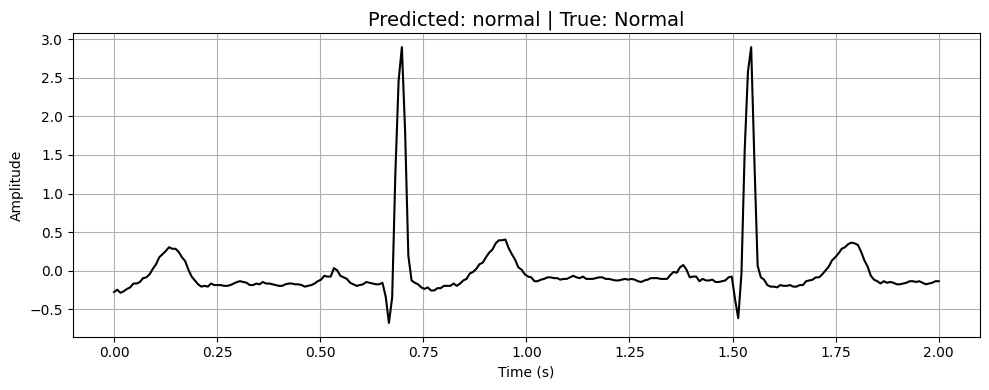

Prediction: normal


In [86]:
complete_pipeline('./user/normal','16786',true_label='Normal')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


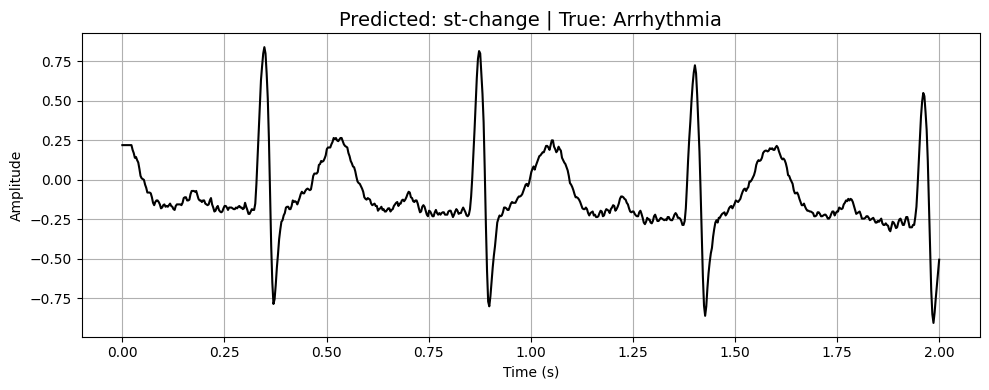

Prediction: st-change


In [87]:
complete_pipeline('./user/arrhy','215',true_label='Arrhythmia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


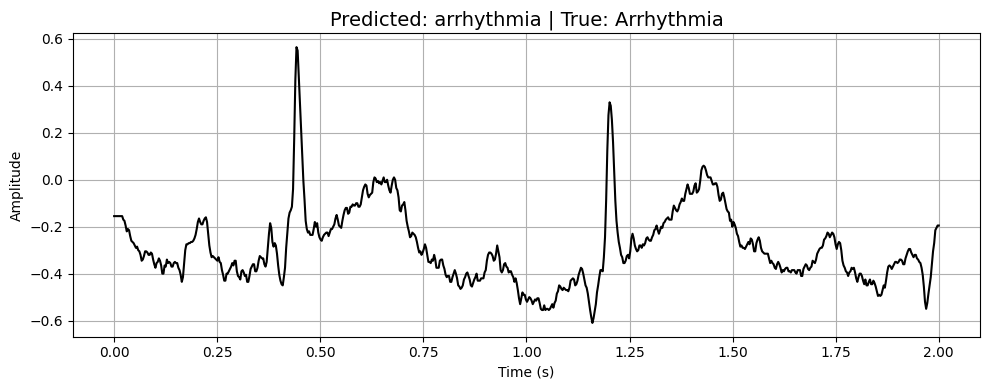

Prediction: arrhythmia


In [88]:
complete_pipeline('./user/arrhy','228',true_label='Arrhythmia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


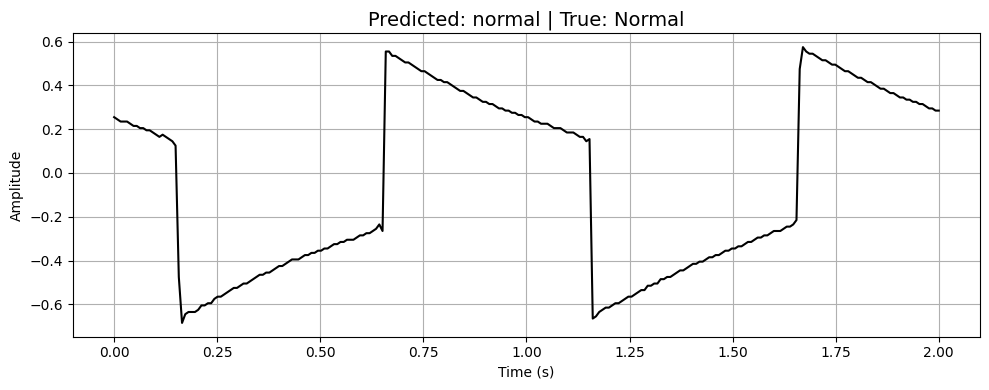

Prediction: normal


In [89]:
complete_pipeline('./user/normal','19140',true_label='Normal')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


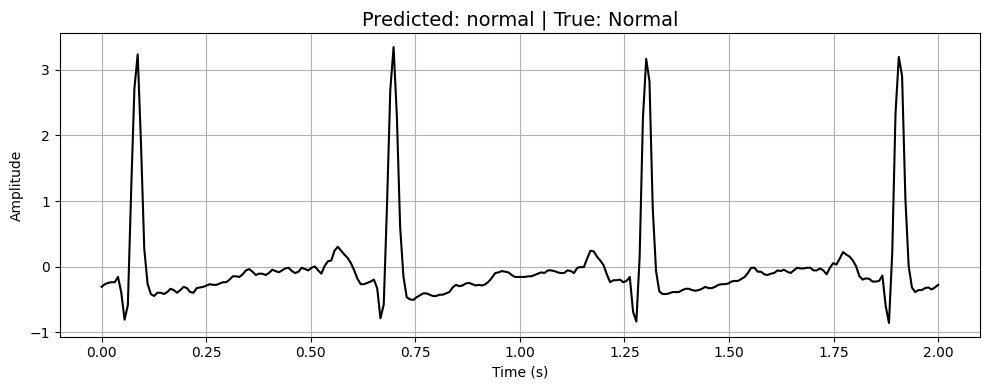

Prediction: normal


In [90]:
complete_pipeline('./user/normal','16273',true_label='Normal')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


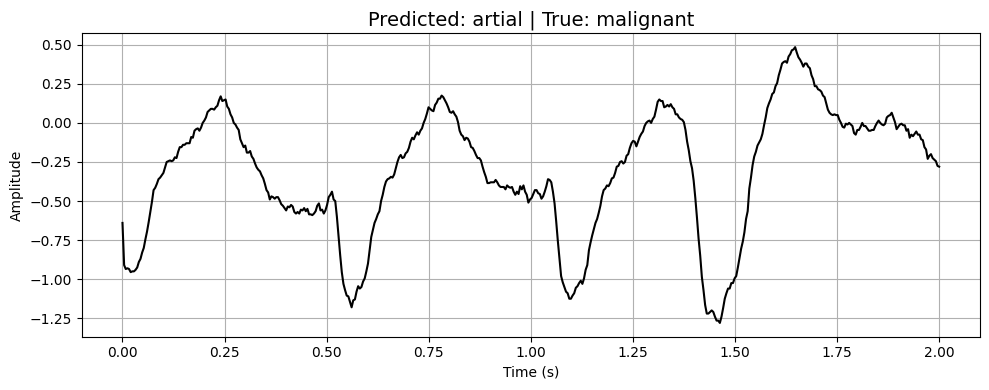

Prediction: artial


In [91]:
complete_pipeline('./user/malignant/','418',true_label='malignant')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


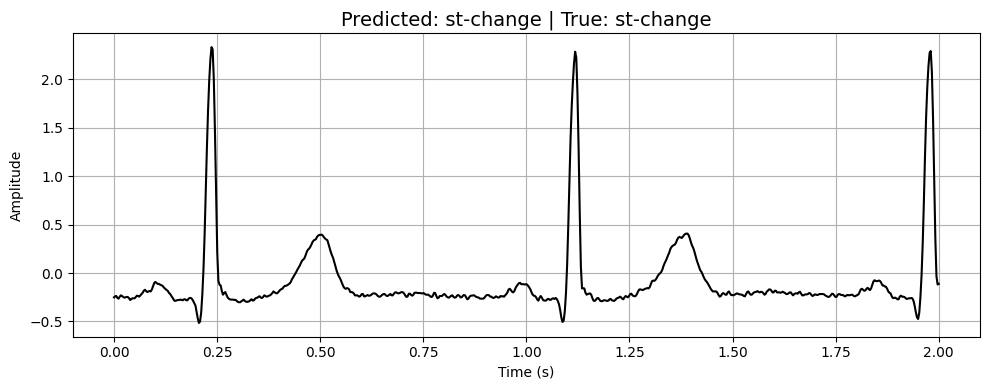

Prediction: st-change


In [92]:
complete_pipeline('./user/st/','313',true_label='st-change')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


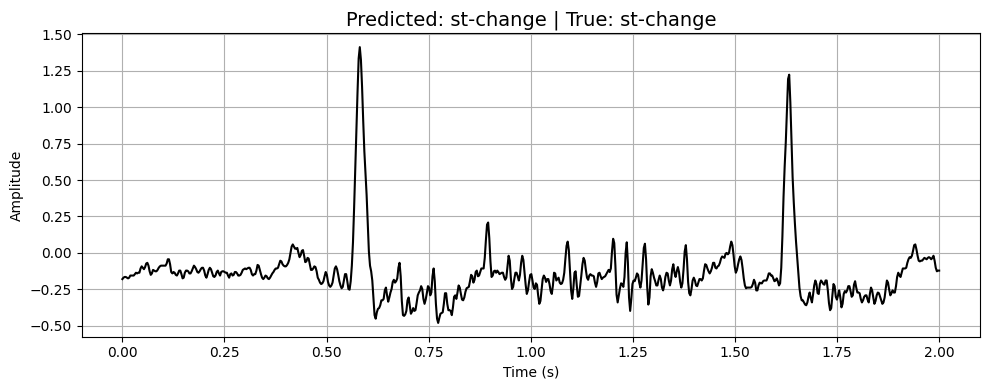

Prediction: st-change


In [93]:
complete_pipeline('./user/st/','314',true_label='st-change')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


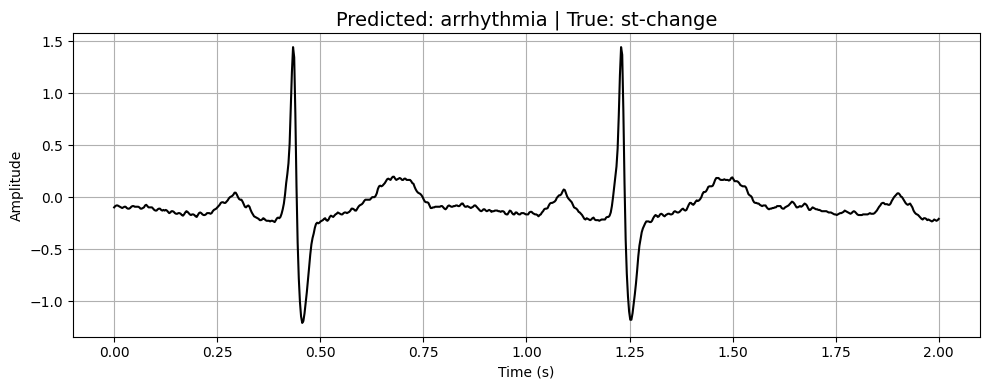

Prediction: arrhythmia


In [94]:
complete_pipeline('./user/st/','321',true_label='st-change')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


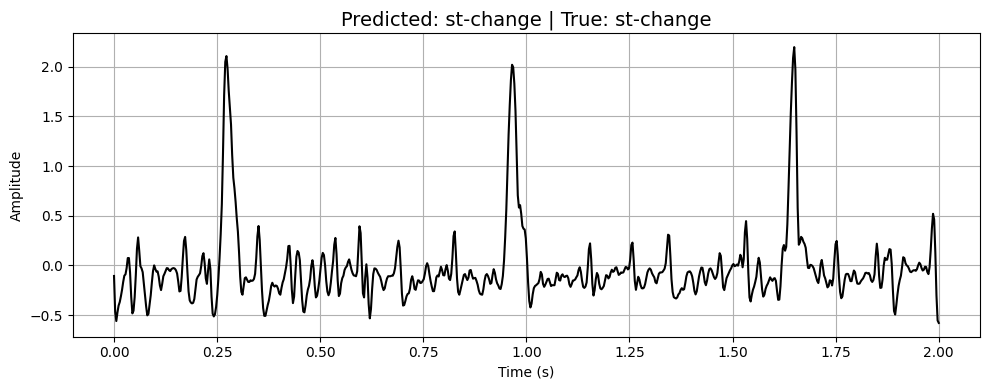

Prediction: st-change


In [95]:
complete_pipeline('./user/st/','322',true_label='st-change')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


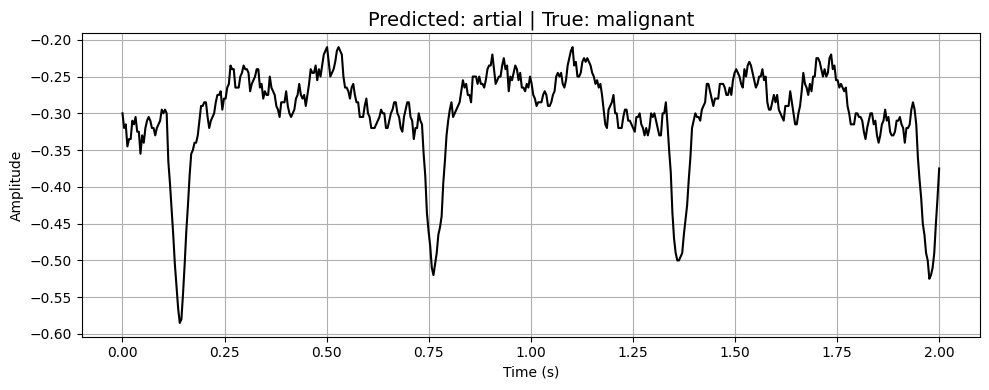

Prediction: artial


In [96]:
complete_pipeline('./user/malignant/','429',true_label='malignant')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


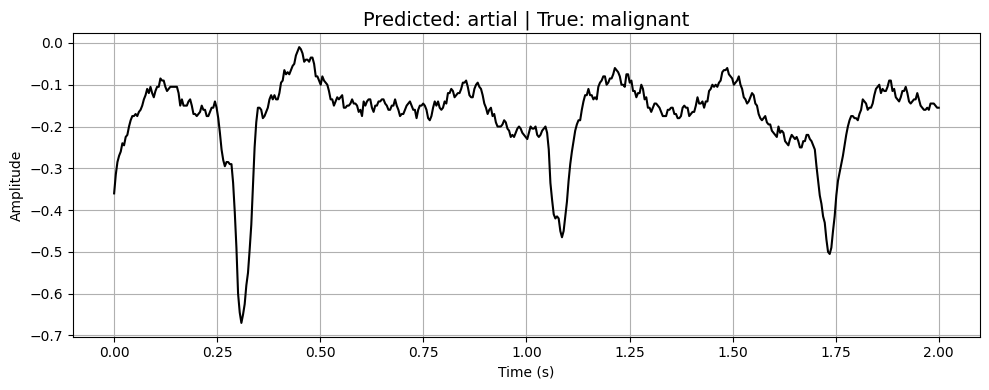

Prediction: artial


In [97]:
complete_pipeline('./user/malignant/','430',true_label='malignant')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


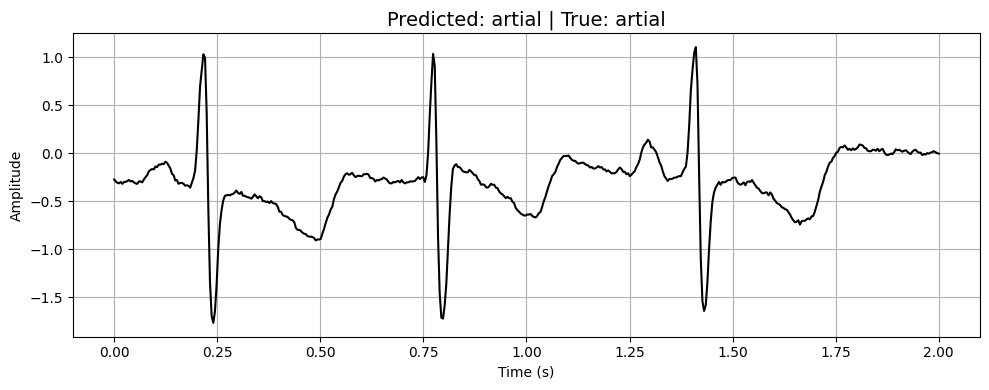

Prediction: artial


In [98]:
complete_pipeline('./user/artial/','04015',true_label='artial')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


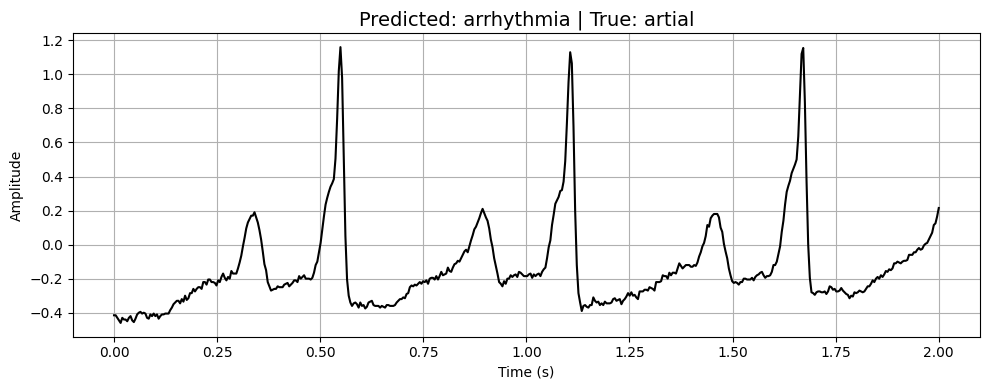

Prediction: arrhythmia


In [99]:
complete_pipeline('./user/artial/','04043',true_label='artial')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


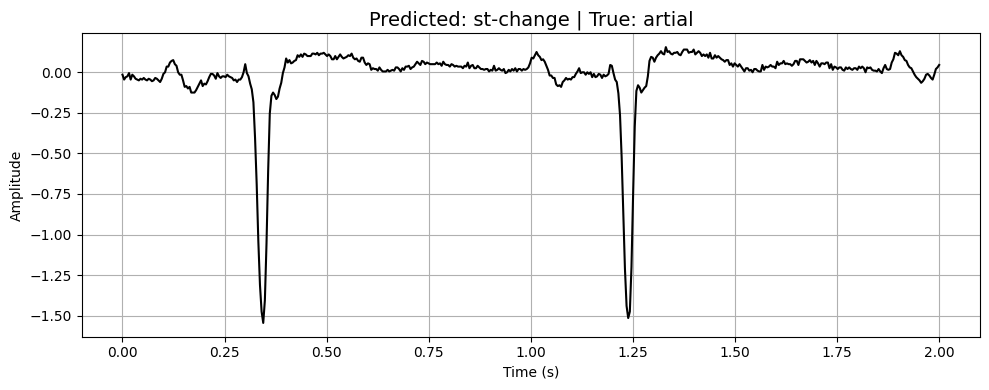

Prediction: st-change


In [100]:
complete_pipeline('./user/artial/','04936',true_label='artial')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


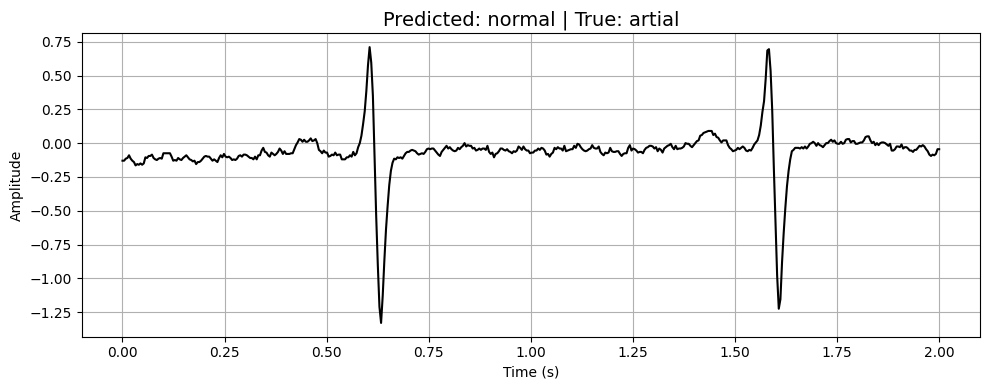

Prediction: normal


In [101]:
complete_pipeline('./user/artial/','05091',true_label='artial')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


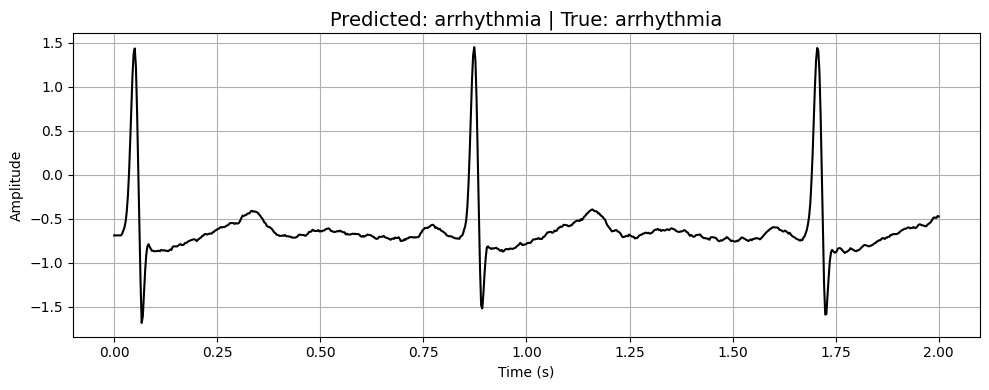

Prediction: arrhythmia


In [102]:
complete_pipeline('./user/arrhy/','220',true_label='arrhythmia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


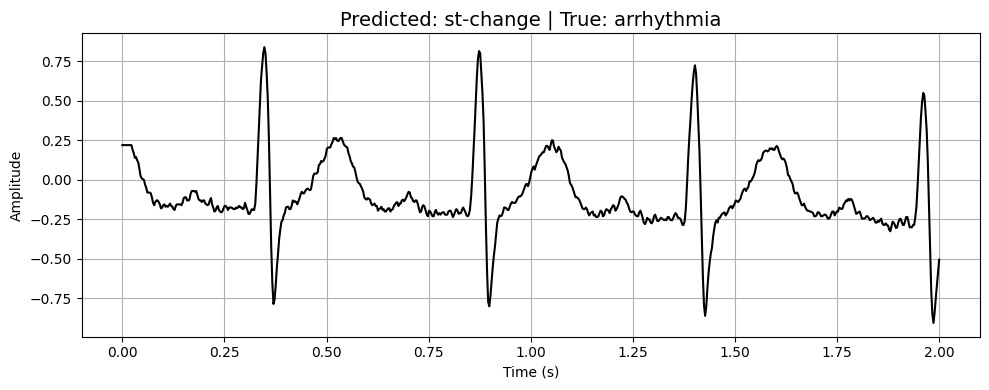

Prediction: st-change


In [103]:
complete_pipeline('./user/arrhy/','215',true_label='arrhythmia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


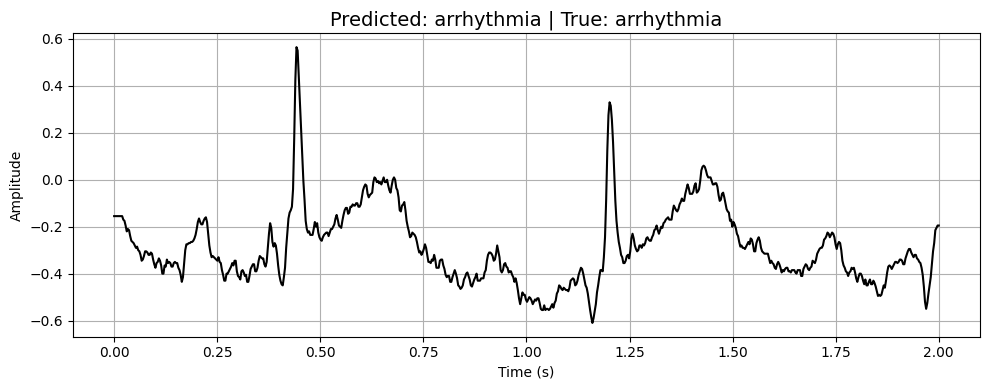

Prediction: arrhythmia


In [104]:
complete_pipeline('./user/arrhy/','228',true_label='arrhythmia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


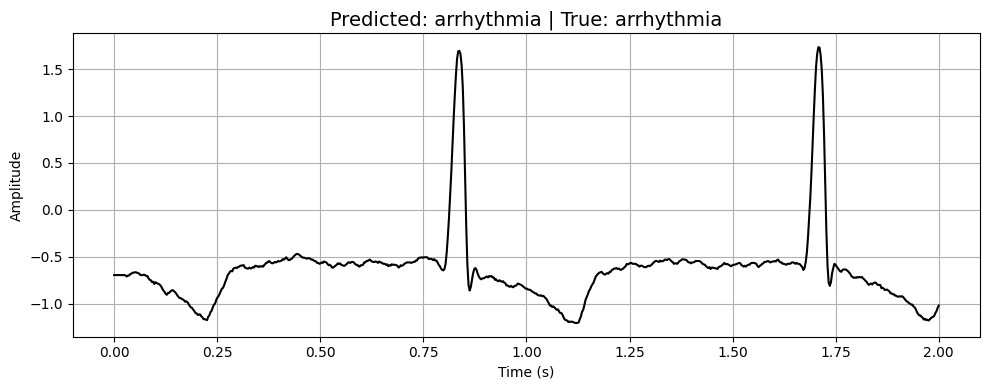

Prediction: arrhythmia


In [105]:
complete_pipeline('./user/arrhy/','219',true_label='arrhythmia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


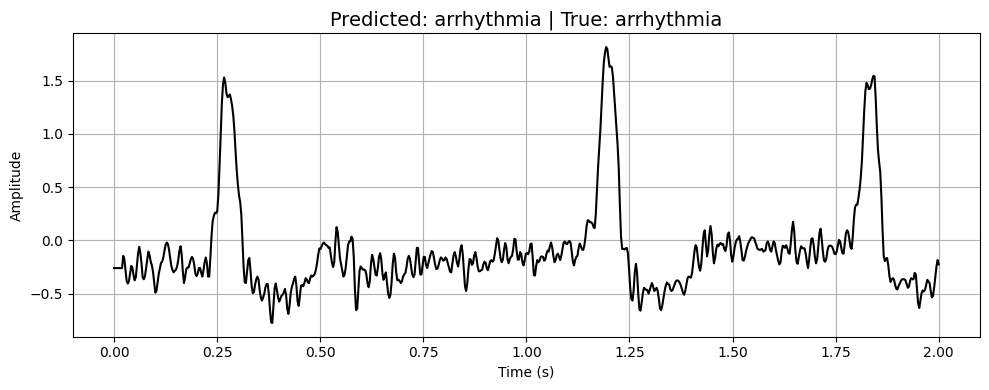

Prediction: arrhythmia


In [106]:
complete_pipeline('./user/arrhy/','203',true_label='arrhythmia')